In [44]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from factor_analyzer import Rotator
from sklearn.preprocessing import StandardScaler

In [45]:
# load ivs_df from pkl
ivs_df = pd.read_pickle("../data/ivs_df.pkl")
variable_view = pd.read_pickle("../data/variable_view.pkl")

In [46]:
ivs_df.head()

,studyno,version,doi,stdyno_w,versn_w,S001,s002,S002EVS,s002vs,S003,...,Y022B,Y022C,Y023,Y023A,Y023B,Y023C,Y024,Y024A,Y024B,Y024C
0,4001.0,4-0-0 (2024-06-30),doi.org/10.14281/18241.27,1562.0,WVS7 v.5.0,2.0,7.0,NaN,7.0,20.0,...,0.66,0.66,0.296296,0.333333,0.111111,0.444444,0.000,0.00,0.0,0.000
1,4001.0,4-0-0 (2024-06-30),doi.org/10.14281/18241.27,1562.0,WVS7 v.5.0,2.0,7.0,NaN,7.0,20.0,...,0.66,0.66,0.888889,0.888889,0.888889,0.888889,0.500,1.00,0.0,0.500
2,4001.0,4-0-0 (2024-06-30),doi.org/10.14281/18241.27,1562.0,WVS7 v.5.0,2.0,7.0,NaN,7.0,20.0,...,0.66,0.66,0.666667,1.000000,0.444444,0.555556,0.415,0.33,0.5,0.415
3,4001.0,4-0-0 (2024-06-30),doi.org/10.14281/18241.27,1562.0,WVS7 v.5.0,2.0,7.0,NaN,7.0,20.0,...,1.00,1.00,0.592593,0.555556,0.333333,0.888889,0.415,0.33,0.5,0.415
4,4001.0,4-0-0 (2024-06-30),doi.org/10.14281/18241.27,1562.0,WVS7 v.5.0,2.0,7.0,NaN,7.0,20.0,...,0.66,0.66,0.629630,0.777778,0.444444,0.666667,0.250,0.00,0.5,0.250


In [47]:
variable_view.head()

,Name,Type,Width,Label,Missing,Measure,Align
0,studyno,Numeric,10,Study number,None,nominal,unknown
1,version,String,26,Version,None,nominal,unknown
2,doi,String,26,Digital Object Identifier,None,nominal,unknown
3,stdyno_w,Numeric,10,Study number (wave),None,nominal,unknown
4,versn_w,String,90,Version (wave),None,nominal,unknown


We need to filter down to the three most recent survey waves (from 2005 onwards). The most recent survey waves provide up-to-date information on cultural values, ensuring that the analysis reflects current societal norms and attitudes. We also filter out the ten questions from the IVS that form the basis of the Inglehart-Welzel Cultural Map. 

In [48]:
# Metadata we need
meta_col = ["S020", "S003"]
# Weights
weights = ["S017"]
# Use the ten questions from the IVS that form the basis of the Inglehart-Welzel Cultural Map
iv_qns = ["A008", "A165", "E018", "E025", "F063", "F118", "F120", "G006", "Y002", "Y003"]

In [49]:
subset_ivs_df = ivs_df[meta_col+weights+iv_qns]
subset_ivs_df.head()

,S020,S003,S017,A008,A165,E018,E025,F063,F118,F120,G006,Y002,Y003
0,2018.0,20.0,1.0,1.0,2.0,1.0,2.0,7.0,4.0,2.0,NaN,1.0,0.0
1,2018.0,20.0,1.0,1.0,2.0,1.0,1.0,1.0,9.0,9.0,1.0,3.0,-1.0
2,2018.0,20.0,1.0,2.0,2.0,1.0,1.0,8.0,10.0,5.0,3.0,2.0,2.0
3,2018.0,20.0,1.0,2.0,2.0,2.0,2.0,1.0,6.0,4.0,NaN,2.0,0.0
4,2018.0,20.0,1.0,2.0,2.0,2.0,1.0,4.0,8.0,5.0,NaN,1.0,1.0


In [50]:
subset_ivs_df.describe()

,S020,S003,S017,A008,A165,E018,E025,F063,F118,F120,G006,Y002,Y003
count,666907.000000,666907.000000,666907.000000,653006.000000,640372.000000,624982.000000,606033.000000,633123.000000,606363.000000,629651.000000,634203.000000,625175.000000,654446.000000
mean,2005.453414,448.674458,0.999952,1.931601,1.716619,1.542968,2.061936,7.141333,3.592447,3.827039,1.591057,1.800662,-0.990749
std,10.481040,257.830151,0.434010,0.726013,0.450640,0.733853,0.821852,3.219945,3.266736,3.011018,0.758780,0.626261,1.730594
min,1981.000000,8.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-3.000000
25%,1998.000000,231.000000,0.878843,1.000000,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,-3.000000
50%,2007.000000,428.000000,1.000000,2.000000,2.000000,1.000000,2.000000,8.000000,1.000000,3.000000,1.000000,2.000000,-1.000000
75%,2014.000000,703.000000,1.000000,2.000000,2.000000,2.000000,3.000000,10.000000,6.000000,6.000000,2.000000,2.000000,0.000000
max,2023.000000,915.000000,32.250881,4.000000,2.000000,3.000000,3.000000,10.000000,10.000000,10.000000,4.000000,3.000000,2.000000


In [51]:
subset_ivs_df.isna().sum()

S020        0
S003        0
S017        0
A008    13901
A165    26535
E018    41925
E025    60874
F063    33784
F118    60544
F120    37256
G006    32704
Y002    41732
Y003    12461
dtype: int64

In [52]:
subset_ivs_df = subset_ivs_df.rename(columns={'S020': 'year', 'S003': 'country_code', 'S017': 'weight'})

In [53]:
subset_ivs_df.head()

,year,country_code,weight,A008,A165,E018,E025,F063,F118,F120,G006,Y002,Y003
0,2018.0,20.0,1.0,1.0,2.0,1.0,2.0,7.0,4.0,2.0,NaN,1.0,0.0
1,2018.0,20.0,1.0,1.0,2.0,1.0,1.0,1.0,9.0,9.0,1.0,3.0,-1.0
2,2018.0,20.0,1.0,2.0,2.0,1.0,1.0,8.0,10.0,5.0,3.0,2.0,2.0
3,2018.0,20.0,1.0,2.0,2.0,2.0,2.0,1.0,6.0,4.0,NaN,2.0,0.0
4,2018.0,20.0,1.0,2.0,2.0,2.0,1.0,4.0,8.0,5.0,NaN,1.0,1.0


In [54]:
# remove before 2005
subset_ivs_df = subset_ivs_df[subset_ivs_df["year"] >= 2005]

In [85]:
subset_ivs_df.head()

,year,country_code,weight,A008,A165,E018,E025,F063,F118,F120,G006,Y002,Y003
0,2018.0,20.0,1.0,1.0,2.0,1.0,2.0,7.0,4.0,2.0,NaN,1.0,0.0
1,2018.0,20.0,1.0,1.0,2.0,1.0,1.0,1.0,9.0,9.0,1.0,3.0,-1.0
2,2018.0,20.0,1.0,2.0,2.0,1.0,1.0,8.0,10.0,5.0,3.0,2.0,2.0
3,2018.0,20.0,1.0,2.0,2.0,2.0,2.0,1.0,6.0,4.0,NaN,2.0,0.0
4,2018.0,20.0,1.0,2.0,2.0,2.0,1.0,4.0,8.0,5.0,NaN,1.0,1.0


In [56]:
len(subset_ivs_df["country_code"].unique())

112

In [57]:
len(subset_ivs_df)

394524

The joint IVS data, after filtering, covers 394,524 individual-level survey response observations from 112 countries.

# Country Names and Metadata

We also need to collect the country names and metadata for the countries in our dataset. We will use this information to map the countries to their respective cultural regions and to identify Islamic countries.

In [88]:
data = {
    "Country": ["Afghanistan", "Albania", "Algeria", "American Samoa", "Andorra", "Angola", "Anguilla", 
                "Antarctica", "Antigua and Barbuda", "Argentina", "Armenia", "Aruba", "Australia", "Austria", 
                "Azerbaijan", "Bahamas (the)", "Bahrain", "Bangladesh", "Barbados", "Belarus", "Belgium", 
                "Belize", "Benin", "Bermuda", "Bhutan", "Bolivia (Plurinational State of)", 
                "Bonaire, Sint Eustatius and Saba", "Bosnia and Herzegovina", "Botswana", "Bouvet Island", 
                "Brazil", "British Indian Ocean Territory (the)", "Brunei Darussalam", "Bulgaria", 
                "Burkina Faso", "Burundi", "Cabo Verde", "Cambodia", "Cameroon", "Canada", "Cayman Islands (the)", 
                "Central African Republic (the)", "Chad", "Chile", "China", "Christmas Island", 
                "Cocos (Keeling) Islands (the)", "Colombia", "Comoros (the)", "Congo (the Democratic Republic of the)", 
                "Congo (the)", "Cook Islands (the)", "Costa Rica", "Croatia", "Cuba", "Curaçao", "Cyprus", 
                "Czechia", "Côte d'Ivoire", "Denmark", "Djibouti", "Dominica", "Dominican Republic (the)", 
                "Ecuador", "Egypt", "El Salvador", "Equatorial Guinea", "Eritrea", "Estonia", "Eswatini", 
                "Ethiopia", "Falkland Islands (the) [Malvinas]", "Faroe Islands (the)", "Fiji", "Finland", 
                "France", "French Guiana", "French Polynesia", "French Southern Territories (the)", "Gabon", 
                "Gambia (the)", "Georgia", "Germany", "Ghana", "Gibraltar", "Greece", "Greenland", "Grenada", 
                "Guadeloupe", "Guam", "Guatemala", "Guernsey", "Guinea", "Guinea-Bissau", "Guyana", "Haiti", 
                "Heard Island and McDonald Islands", "Holy See (the)", "Honduras", "Hong Kong", "Hungary", "Iceland", 
                "India", "Indonesia", "Iran (Islamic Republic of)", "Iraq", "Ireland", "Isle of Man", "Israel", 
                "Italy", "Jamaica", "Japan", "Jersey", "Jordan", "Kazakhstan", "Kenya", "Kiribati", 
                "Korea (the Democratic People's Republic of)", "Korea (the Republic of)", "Kuwait", "Kyrgyzstan", 
                "Lao People's Democratic Republic (the)", "Latvia", "Lebanon", "Lesotho", "Liberia", "Libya", 
                "Liechtenstein", "Lithuania", "Luxembourg", "Macao", "Madagascar", "Malawi", "Malaysia", "Maldives", 
                "Mali", "Malta", "Marshall Islands (the)", "Martinique", "Mauritania", "Mauritius", "Mayotte", 
                "Mexico", "Micronesia (Federated States of)", "Moldova (the Republic of)", "Monaco", "Mongolia", 
                "Montenegro", "Montserrat", "Morocco", "Mozambique", "Myanmar", "Namibia", "Nauru", "Nepal", 
                "Netherlands (the)", "New Caledonia", "New Zealand", "Nicaragua", "Niger (the)", "Nigeria", 
                "Niue", "Norfolk Island", "Northern Mariana Islands (the)", "Norway", "Oman", "Pakistan", "Palau", 
                "Palestine, State of", "Panama", "Papua New Guinea", "Paraguay", "Peru", "Philippines (the)", 
                "Pitcairn", "Poland", "Portugal", "Puerto Rico", "Qatar", "Republic of North Macedonia", "Romania", 
                "Russian Federation (the)", "Rwanda", "Réunion", "Saint Barthélemy", 
                "Saint Helena, Ascension and Tristan da Cunha", "Saint Kitts and Nevis", "Saint Lucia", 
                "Saint Martin (French part)", "Saint Pierre and Miquelon", "Saint Vincent and the Grenadines", "Samoa", 
                "San Marino", "Sao Tome and Principe", "Saudi Arabia", "Senegal", "Serbia", "Seychelles", 
                "Sierra Leone", "Singapore", "Sint Maarten (Dutch part)", "Slovakia", "Slovenia", "Solomon Islands", 
                "Somalia", "South Africa", "South Georgia and the South Sandwich Islands", "South Sudan", "Spain", 
                "Sri Lanka", "Sudan (the)", "Suriname", "Svalbard and Jan Mayen", "Sweden", "Switzerland", 
                "Syrian Arab Republic", "Taiwan (Province of China)", "Tajikistan", "Tanzania, United Republic of", 
                "Thailand", "Timor-Leste", "Togo", "Tokelau", "Tonga", "Trinidad and Tobago", "Tunisia", "Turkey", 
                "Turkmenistan", "Turks and Caicos Islands (the)", "Tuvalu", "Uganda", "Ukraine", "United Arab Emirates (the)", 
                "United Kingdom of Great Britain and Northern Ireland (the)", "United States Minor Outlying Islands (the)", 
                "United States of America (the)", "Uruguay", "Uzbekistan", "Vanuatu", "Venezuela (Bolivarian Republic of)", 
                "Viet Nam", "Virgin Islands (British)", "Virgin Islands (U.S.)", "Wallis and Futuna", "Western Sahara", 
                "Yemen", "Zambia", "Zimbabwe", "Åland Islands"],
    "Numeric": [4, 8, 12, 16, 20, 24, 660, 10, 28, 32, 51, 533, 36, 40, 31, 44, 48, 50, 52, 112, 56, 84, 204, 60, 64, 
                68, 535, 70, 72, 74, 76, 86, 96, 100, 854, 108, 132, 116, 120, 124, 136, 140, 148, 152, 156, 162, 
                166, 170, 174, 180, 178, 184, 188, 191, 192, 531, 196, 203, 384, 208, 262, 212, 214, 218, 818, 222, 
                226, 232, 233, 748, 231, 238, 234, 242, 246, 250, 254, 258, 260, 266, 270, 268, 276, 288, 292, 300, 
                304, 308, 312, 316, 320, 831, 324, 624, 328, 332, 334, 336, 340, 344, 348, 352, 356, 360, 364, 368, 
                372, 833, 376, 380, 388, 392, 832, 400, 398, 404, 296, 408, 410, 414, 417, 418, 428, 422, 426, 430, 
                434, 438, 440, 442, 446, 450, 454, 458, 462, 466, 470, 584, 474, 478, 480, 175, 484, 583, 498, 492, 
                496, 499, 500, 504, 508, 104, 516, 520, 524, 528, 540, 554, 558, 562, 566, 570, 574, 580, 578, 512, 
                586, 585, 275, 591, 598, 600, 604, 608, 612, 616, 620, 630, 634, 807, 642, 643, 646, 638, 652, 654, 
                659, 662, 663, 666, 670, 882, 674, 678, 682, 686, 688, 690, 694, 702, 534, 703, 705, 90, 706, 710, 
                239, 728, 724, 144, 729, 740, 744, 752, 756, 760, 158, 762, 834, 764, 626, 768, 772, 776, 780, 788, 
                792, 795, 796, 798, 800, 804, 784, 826, 581, 840, 858, 860, 548, 862, 704, 92, 850, 876, 732, 887, 
                894, 716, 248]
}

country_codes = pd.DataFrame(data)
country_codes

,Country,Numeric
0,Afghanistan,4
1,Albania,8
2,Algeria,12
3,American Samoa,16
4,Andorra,20
...,...,...
244,Western Sahara,732
245,Yemen,887
246,Zambia,894
247,Zimbabwe,716


In [87]:
unique_countries = subset_ivs_df["country_code"].unique()
unique_countries

array([ 20.,  32.,  36.,  50.,  51.,  68.,  76.,   8., 104.,  12., 124.,
       152., 156., 158., 170., 196., 203., 218., 231., 276., 300.,  31.,
       320., 344., 356., 360., 364., 368., 392., 398.,  40., 400., 404.,
       410., 417., 422., 434., 446., 458., 462., 484., 496., 504., 528.,
       554., 558.,  56., 566., 586., 604., 608., 630., 642., 643., 688.,
        70., 702., 703., 704., 716., 762., 764., 788., 792., 804., 818.,
       826., 840., 858., 860., 862., 909., 100., 112., 191., 197., 208.,
       233., 246., 250., 268., 275., 288., 332., 348., 352., 372., 380.,
       414., 428., 440., 442., 466., 470., 498., 499., 578., 616., 620.,
       634., 646., 705., 710., 724., 752., 756., 780., 807., 854., 887.,
       894., 915.])

In [60]:
country_codes = country_codes[country_codes["Numeric"].isin(unique_countries)]
country_codes

,Country,Numeric
1,Albania,8
2,Algeria,12
4,Andorra,20
9,Argentina,32
10,Armenia,51
...,...,...
239,Venezuela (Bolivarian Republic of),862
240,Viet Nam,704
245,Yemen,887
246,Zambia,894


In [89]:
# Adding cultural regions for the regions in our dataset

cultural_regions = {
    'Albania': 'Orthodox Europe',
    'Algeria': 'African-Islamic',
    'Andorra': 'Catholic Europe',
    'Argentina': 'Latin America',
    'Armenia': 'Orthodox Europe',
    'Australia': 'English-Speaking',
    'Austria': 'Catholic Europe',
    'Azerbaijan': 'Orthodox Europe',
    'Bangladesh': 'West & South Asia',
    'Belarus': 'Orthodox Europe',
    'Belgium': 'Catholic Europe',
    'Bolivia (Plurinational State of)': 'Latin America',
    'Bosnia and Herzegovina': 'Orthodox Europe',
    'Brazil': 'Latin America',
    'Bulgaria': 'Orthodox Europe',
    'Burkina Faso': 'African-Islamic',
    'Canada': 'English-Speaking',
    'Chile': 'Latin America',
    'China': 'Confucian',
    'Colombia': 'Latin America',
    'Croatia': 'Catholic Europe',
    'Cyprus': 'Catholic Europe',
    'Czechia': 'Catholic Europe',
    'Denmark': 'Protestant Europe',
    'Ecuador': 'Latin America',
    'Egypt': 'African-Islamic',
    'Estonia': 'Orthodox Europe',
    'Ethiopia': 'African-Islamic',
    'Finland': 'Protestant Europe',
    'France': 'Catholic Europe',
    'Georgia': 'Orthodox Europe',
    'Germany': 'Protestant Europe',
    'Ghana': 'African-Islamic',
    'Greece': 'Orthodox Europe',
    'Guatemala': 'Latin America',
    'Haiti': 'Latin America',
    'Hong Kong': 'Confucian',
    'Hungary': 'Catholic Europe',
    'Iceland': 'Protestant Europe',
    'India': 'West & South Asia',
    'Indonesia': 'West & South Asia',
    'Iran (Islamic Republic of)': 'West & South Asia',
    'Iraq': 'African-Islamic',
    'Ireland': 'Catholic Europe',
    'Italy': 'Catholic Europe',
    'Japan': 'Confucian',
    'Jordan': 'African-Islamic',
    'Kazakhstan': 'Orthodox Europe',
    'Kenya': 'African-Islamic',
    'Korea (the Republic of)': 'Confucian',
    'Kuwait': 'African-Islamic',
    'Kyrgyzstan': 'West & South Asia',
    'Latvia': 'Orthodox Europe',
    'Lebanon': 'African-Islamic',
    'Libya': 'African-Islamic',
    'Lithuania': 'Orthodox Europe',
    'Luxembourg': 'Catholic Europe',
    'Macao': 'Confucian',
    'Malaysia': 'West & South Asia',
    'Maldives': 'West & South Asia',
    'Mali': 'African-Islamic',
    'Malta': 'Catholic Europe',
    'Mexico': 'Latin America',
    'Moldova (the Republic of)': 'Orthodox Europe',
    'Mongolia': 'Confucian',
    'Montenegro': 'Orthodox Europe',
    'Morocco': 'African-Islamic',
    'Myanmar': 'West & South Asia',
    'Netherlands (the)': 'Protestant Europe',
    'New Zealand': 'English-Speaking',
    'Nicaragua': 'Latin America',
    'Nigeria': 'African-Islamic',
    'Norway': 'Protestant Europe',
    'Pakistan': 'West & South Asia',
    'Palestine, State of': 'African-Islamic',
    'Peru': 'Latin America',
    'Philippines (the)': 'West & South Asia',
    'Poland': 'Catholic Europe',
    'Portugal': 'Catholic Europe',
    'Puerto Rico': 'Latin America',
    'Qatar': 'African-Islamic',
    'Republic of North Macedonia': 'Orthodox Europe',
    'Romania': 'Orthodox Europe',
    'Russian Federation (the)': 'Orthodox Europe',
    'Rwanda': 'African-Islamic',
    'Serbia': 'Orthodox Europe',
    'Singapore': 'Confucian',
    'Slovakia': 'Catholic Europe',
    'Slovenia': 'Catholic Europe',
    'South Africa': 'English-Speaking',
    'Spain': 'Catholic Europe',
    'Sweden': 'Protestant Europe',
    'Switzerland': 'Protestant Europe',
    'Taiwan (Province of China)': 'Confucian',
    'Tajikistan': 'West & South Asia',
    'Thailand': 'Confucian',
    'Trinidad and Tobago': 'Latin America',
    'Tunisia': 'African-Islamic',
    'Turkey': 'West & South Asia',
    'Ukraine': 'Orthodox Europe',
    'United Kingdom of Great Britain and Northern Ireland (the)': 'English-Speaking',
    'United States of America (the)': 'English-Speaking',
    'Uruguay': 'Latin America',
    'Uzbekistan': 'West & South Asia',
    'Venezuela (Bolivarian Republic of)': 'Latin America',
    'Viet Nam': 'Confucian',
    'Yemen': 'African-Islamic',
    'Zambia': 'African-Islamic',
    'Zimbabwe': 'African-Islamic',
}

In [90]:
# boolean values indicating whether the country is Islamic

islamic_countries = {
    'Albania': True,
    'Algeria': True,
    'Andorra': False,
    'Argentina': False,
    'Armenia': False,
    'Australia': False,
    'Austria': False,
    'Azerbaijan': True,
    'Bangladesh': True,
    'Belarus': False,
    'Belgium': False,
    'Bolivia (Plurinational State of)': False,
    'Bosnia and Herzegovina': True,
    'Brazil': False,
    'Bulgaria': False,
    'Burkina Faso': True,
    'Canada': False,
    'Chile': False,
    'China': False,
    'Colombia': False,
    'Croatia': False,
    'Cyprus': False,
    'Czechia': False,
    'Denmark': False,
    'Ecuador': False,
    'Egypt': True,
    'Estonia': False,
    'Ethiopia': False,
    'Finland': False,
    'France': False,
    'Georgia': False,
    'Germany': False,
    'Ghana': True,
    'Greece': False,
    'Guatemala': False,
    'Haiti': False,
    'Hong Kong': False,
    'Hungary': False,
    'Iceland': False,
    'India': False,
    'Indonesia': True,
    'Iran (Islamic Republic of)': True,
    'Iraq': True,
    'Ireland': False,
    'Italy': False,
    'Japan': False,
    'Jordan': True,
    'Kazakhstan': True,
    'Kenya': True,
    'Korea (the Republic of)': False,
    'Kuwait': True,
    'Kyrgyzstan': True,
    'Latvia': False,
    'Lebanon': True,
    'Libya': True,
    'Lithuania': False,
    'Luxembourg': False,
    'Macao': False,
    'Malaysia': True,
    'Maldives': True,
    'Mali': True,
    'Malta': False,
    'Mexico': False,
    'Moldova (the Republic of)': False,
    'Mongolia': False,
    'Montenegro': False,
    'Morocco': True,
    'Myanmar': False,
    'Netherlands (the)': False,
    'New Zealand': False,
    'Nicaragua': False,
    'Nigeria': True,
    'Norway': False,
    'Pakistan': True,
    'Palestine, State of': True,
    'Peru': False,
    'Philippines (the)': False,
    'Poland': False,
    'Portugal': False,
    'Puerto Rico': False,
    'Qatar': True,
    'Republic of North Macedonia': False,
    'Romania': False,
    'Russian Federation (the)': False,
    'Rwanda': True,
    'Serbia': False,
    'Singapore': False,
    'Slovakia': False,
    'Slovenia': False,
    'South Africa': False,
    'Spain': False,
    'Sweden': False,
    'Switzerland': False,
    'Taiwan (Province of China)': False,
    'Tajikistan': True,
    'Thailand': False,
    'Trinidad and Tobago': False,
    'Tunisia': True,
    'Turkey': True,
    'Ukraine': False,
    'United Kingdom of Great Britain and Northern Ireland (the)': False,
    'United States of America (the)': False,
    'Uruguay': False,
    'Uzbekistan': True,
    'Venezuela (Bolivarian Republic of)': False,
    'Viet Nam': False,
    'Yemen': True,
    'Zambia': True,
    'Zimbabwe': False,
}

In [74]:
# We need columns of "Islamic" and categorise the countries based on the region
# Add cultural regions column
country_codes = country_codes.copy()
country_codes['Cultural Region'] = country_codes['Country'].map(cultural_regions)
country_codes['Islamic'] = country_codes['Country'].map(islamic_countries)
country_codes.head()

,Country,Numeric,Cultural Region,Islamic
1,Albania,8,Orthodox Europe,True
2,Algeria,12,African-Islamic,True
4,Andorra,20,Catholic Europe,False
9,Argentina,32,Latin America,False
10,Armenia,51,Orthodox Europe,False


In [75]:
country_codes.to_pickle("../data/country_codes.pkl")

# Methodology

In [64]:
print(f"{round(((len(subset_ivs_df) - len(subset_ivs_df.dropna()) )/ len(subset_ivs_df))*100, 2)} % of the data is incomplete")

28.77 % of the data is incomplete


Standardize the Data: Standardize the survey responses, considering the weights. You can use the StandardScaler from scikit-learn with sample weights.

In [65]:
weights = subset_ivs_df['weight'].values
features = subset_ivs_df[iv_qns].values
scaler = StandardScaler()
standardized_data = scaler.fit_transform(features, sample_weight=weights)
standardized_data

array([[-1.25368551,  0.61114223, -0.73859636, ...,         nan,
        -1.28809506,  0.52177228],
       [-1.25368551,  0.61114223, -0.73859636, ..., -0.77827388,
         1.94826252, -0.057251  ],
       [ 0.1458799 ,  0.61114223, -0.73859636, ...,  1.95268757,
         0.33008373,  1.67981886],
       ...,
       [ 0.1458799 ,  0.61114223, -0.73859636, ...,         nan,
         0.33008373, -1.21529757],
       [-1.25368551,  0.61114223, -0.73859636, ...,         nan,
         0.33008373, -1.21529757],
       [ 0.1458799 ,  0.61114223,  2.01213475, ...,         nan,
         0.33008373, -1.21529757]])

Handle Missing Data: Use pairwise deletion to compute the correlation matrix, taking into account the weights.

In [78]:
# random 10 by 20 matrix
data = np.random.rand(10, 20)
# Randomly mask 10% of the data
mask = np.random.choice([True, False], data.shape, p=[0.1, 0.9])
data[mask] = np.nan
data

array([[0.89064613, 0.61031797,        nan, 0.81508273, 0.65074292,
        0.87504457, 0.61115132, 0.17040361, 0.96846122, 0.51978064,
        0.59275938, 0.30400083, 0.81870916, 0.33992488, 0.11951431,
        0.21944242, 0.78701641, 0.15158161, 0.53188365, 0.53695227],
       [       nan, 0.03506996, 0.84653192,        nan, 0.51295028,
        0.79510087, 0.86228485, 0.82867468, 0.41481079, 0.60700063,
        0.41095847, 0.52458249, 0.74931285, 0.87407083,        nan,
        0.48625116, 0.26668695,        nan,        nan, 0.25174713],
       [0.05579817, 0.11342991, 0.76907063, 0.74856496,        nan,
        0.45181917,        nan, 0.51735543, 0.45851416, 0.05637015,
               nan, 0.24273702, 0.24934328, 0.84356078, 0.95578404,
        0.67237098, 0.2711963 ,        nan, 0.69915722, 0.41426302],
       [0.84757509, 0.19685693, 0.15295301, 0.98292677, 0.2718409 ,
        0.4906886 , 0.81665241,        nan, 0.17134654, 0.92649207,
        0.28396913, 0.50510177, 0.39924168, 0

In [73]:
# Verify standardization
print(pd.DataFrame(standardized_data).dropna().mean(), pd.DataFrame(standardized_data).dropna().std())


0   -0.043026
1   -0.005715
2    0.007339
3   -0.027427
4   -0.031291
5    0.027010
6    0.023107
7   -0.006079
8    0.033189
9    0.019422
dtype: float64 0    0.977840
1    1.002864
2    1.008944
3    0.999446
4    1.012762
5    1.006992
6    1.008566
7    0.995755
8    0.999177
9    1.005948
dtype: float64


In [68]:
standardized_data.shape

(394524, 10)

In [70]:
# Function to calculate covariance matrix with pairwise deletion
def pairwise_covariance_matrix(data):
    n = data.shape[1]
    cov_matrix = np.zeros((n, n))
    counts = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            # Select the valid pairs
            valid_data = data.iloc[:, [i, j]].dropna()
            if valid_data.shape[0] > 1:  # Ensure there are enough data points to calculate covariance
                cov_matrix[i, j] = np.cov(valid_data.T)[0, 1]
                counts[i, j] = valid_data.shape[0]
    
    # Handle divisions and possible invalid operations
    with np.errstate(invalid='ignore', divide='ignore'):
        cov_matrix = np.divide(cov_matrix, counts)
    
    # Filling NaNs that might have arisen due to no valid pairs
    cov_matrix = np.nan_to_num(cov_matrix)
    
    return cov_matrix


# Calculate pairwise covariance matrix
cov_matrix = pairwise_covariance_matrix(pd.DataFrame(standardized_data))
cov_matrix

array([[ 2.55969202e-06,  2.31224418e-07,  9.65632363e-08,
         1.84980331e-07, -6.26049105e-08, -2.18678549e-07,
        -1.46120000e-08,  4.20616156e-07, -1.75955921e-07,
        -8.05907487e-08],
       [ 2.31224418e-07,  2.62677471e-06, -2.54194925e-07,
         5.00444187e-07,  5.66571669e-07, -6.66578193e-07,
        -5.31011162e-07, -1.08342498e-07, -2.64215064e-07,
         4.90632525e-09],
       [ 9.65632363e-08, -2.54194925e-07,  2.69300062e-06,
        -2.25782167e-07, -5.32420857e-07,  3.66707241e-07,
         3.92375994e-07,  4.62463893e-07,  2.48512574e-07,
         1.68990546e-07],
       [ 1.84980331e-07,  5.00444187e-07, -2.25782167e-07,
         2.73664449e-06,  6.78086523e-07, -1.16110210e-06,
        -8.82167145e-07, -2.83673808e-07, -6.14422334e-07,
         1.37170535e-07],
       [-6.26049105e-08,  5.66571669e-07, -5.32420857e-07,
         6.78086523e-07,  2.61968695e-06, -1.10944062e-06,
        -1.18127328e-06, -6.50370915e-07, -3.31325799e-07,
        -1.

In [27]:
masked_data = np.ma.masked_invalid(standardized_data)
correlation_matrix = np.ma.corrcoef(masked_data, rowvar=False, allow_masked=True).data
correlation_matrix

array([[ 1.        ,  0.08759143,  0.03565664,  0.06723841, -0.02388343,
        -0.07903134, -0.00546625,  0.15713672, -0.06559973, -0.03137282],
       [ 0.08759143,  1.        , -0.09144088,  0.17629423,  0.2087868 ,
        -0.23074268, -0.19203661, -0.03951638, -0.09616319,  0.0018598 ],
       [ 0.03565664, -0.09144088,  1.        , -0.07800155, -0.19174704,
         0.12418284,  0.13889655,  0.16494268,  0.08868394,  0.06277362],
       [ 0.06723841,  0.17629423, -0.07800155,  1.        ,  0.23877708,
        -0.3859216 , -0.30555457, -0.09906108, -0.21550086,  0.04965757],
       [-0.02388343,  0.2087868 , -0.19174704,  0.23877708,  1.        ,
        -0.38836129, -0.43133405, -0.23868811, -0.12131742, -0.00704263],
       [-0.07903134, -0.23074268,  0.12418284, -0.3859216 , -0.38836129,
         1.        ,  0.60545305,  0.13298678,  0.23416933,  0.03045968],
       [-0.00546625, -0.19203661,  0.13889655, -0.30555457, -0.43133405,
         0.60545305,  1.        ,  0.16518278

Perform Weighted PCA: Apply PCA using the correlation matrix and include the observation weights. The PCA class in scikit-learn does not directly support weights, so you may need to use a custom implementation or modify the covariance matrix to account for weights.

In [28]:
# Perform PCA on the correlation matrix
pca = PCA()
principal_components = pca.fit_transform(correlation_matrix)

In [29]:
# Varimax rotation on the PCA loadings
rotator = Rotator(method='varimax')
rotated_loadings = rotator.fit_transform(principal_components)

In [30]:
# Rescale the rotated components
pc1 = rotated_loadings[0]
pc2= rotated_loadings[1]

In [31]:
country_codes

,Country,Numeric,Cultural Region,Islamic
1,Albania,8,Orthodox Europe,True
2,Algeria,12,African-Islamic,True
4,Andorra,20,Catholic Europe,False
9,Argentina,32,Latin America,False
10,Armenia,51,Orthodox Europe,False
...,...,...,...,...
239,Venezuela (Bolivarian Republic of),862,Latin America,False
240,Viet Nam,704,Confucian,False
245,Yemen,887,African-Islamic,True
246,Zambia,894,African-Islamic,True


In [32]:
data_for_pca = subset_ivs_df[['country_code'] + iv_qns].copy()
# Create a DataFrame with the rotated components
data_for_pca['PC1'] = np.dot(data_for_pca.drop(columns='country_code').values, pc1)
# Drop country code and PC1 columns now
data_for_pca['PC2'] = np.dot(data_for_pca.drop(columns=['country_code', 'PC1']).values, pc2)
# Calculate the mean of the rescaled individual-level scores for each country
country_scores_pca = data_for_pca.groupby('country_code')[['PC1', 'PC2']].mean().reset_index()
# Mapping cultural regions to colors
cultural_region_colors = {
    'African-Islamic': 'black',
    'Confucian': 'deepskyblue',
    'Latin America': 'violet',
    'Protestant Europe': 'orange',
    'Catholic Europe': 'gold',
    'English-Speaking': 'green',
    'Orthodox Europe': 'blue',
    'West & South Asia': 'brown'
}

country_scores_pca

,country_code,PC1,PC2
0,8.0,1.749384,1.771726
1,12.0,1.696344,2.244389
2,20.0,1.718869,6.174167
3,31.0,1.593104,1.098496
4,32.0,1.723966,5.063404
...,...,...,...
107,862.0,1.793201,4.046820
108,887.0,1.486400,1.761812
109,894.0,1.754647,2.357264
110,909.0,1.616322,4.287380


In [33]:
# Merge the country codes DataFrame with the country scores DataFrame
# Add country names and cultural regions to the DataFrame  
country_scores_pca = country_scores_pca.merge(country_codes, left_on='country_code', right_on='Numeric', how='left')
country_scores_pca

,country_code,PC1,PC2,Country,Numeric,Cultural Region,Islamic
0,8.0,1.749384,1.771726,Albania,8.0,Orthodox Europe,True
1,12.0,1.696344,2.244389,Algeria,12.0,African-Islamic,True
2,20.0,1.718869,6.174167,Andorra,20.0,Catholic Europe,False
3,31.0,1.593104,1.098496,Azerbaijan,31.0,Orthodox Europe,True
4,32.0,1.723966,5.063404,Argentina,32.0,Latin America,False
...,...,...,...,...,...,...,...
107,862.0,1.793201,4.046820,Venezuela (Bolivarian Republic of),862.0,Latin America,False
108,887.0,1.486400,1.761812,Yemen,887.0,African-Islamic,True
109,894.0,1.754647,2.357264,Zambia,894.0,African-Islamic,True
110,909.0,1.616322,4.287380,NaN,NaN,NaN,NaN


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


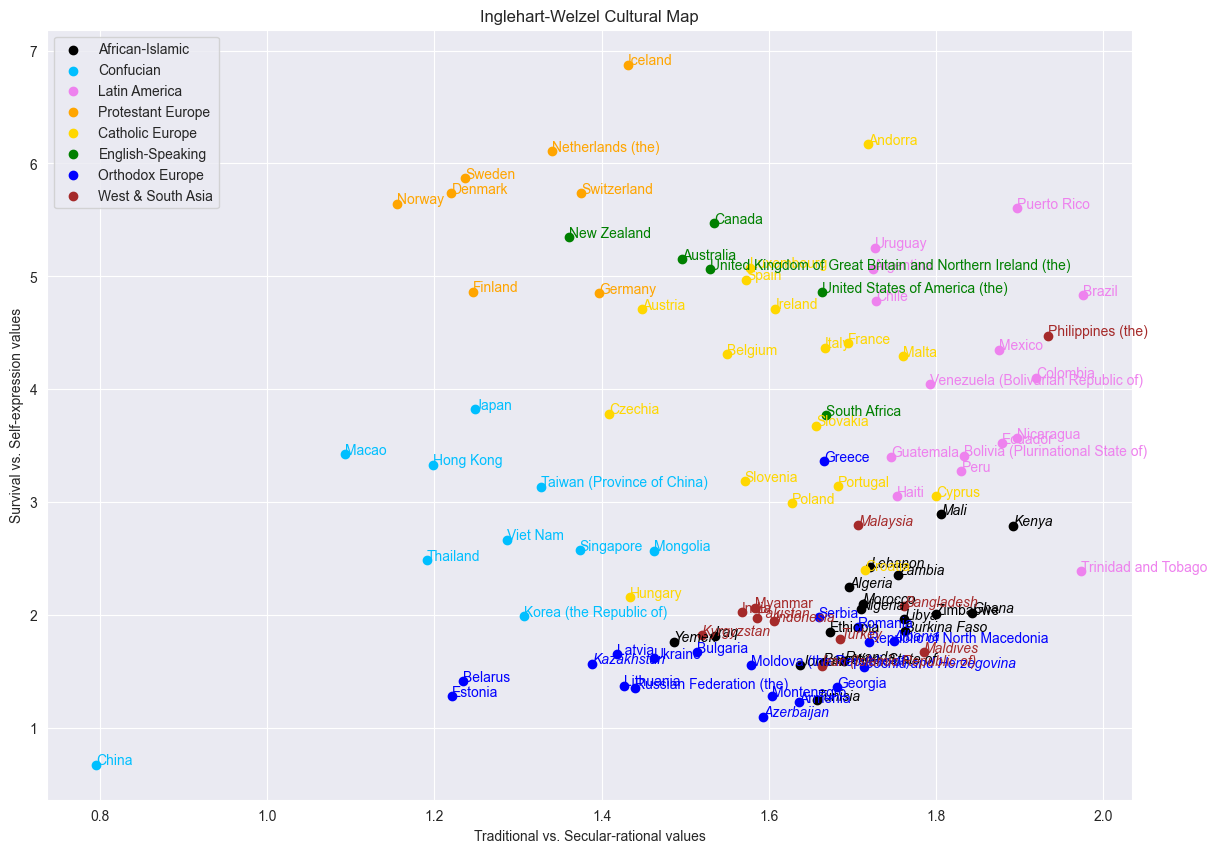

In [34]:
# Plot the Cultural Map
plt.figure(figsize=(14, 10))

# Plot each cultural region with corresponding color and style
for region, color in cultural_region_colors.items():
    subset = country_scores_pca[country_scores_pca['Cultural Region'] == region]
    for i, row in subset.iterrows():
        if row['Islamic']:
            plt.text(row['PC1'], row['PC2'], row['Country'], color=color, fontsize=10, fontstyle='italic')
        else:
            plt.text(row['PC1'], row['PC2'], row['Country'], color=color, fontsize=10)

# Create a scatter plot with colored points based on cultural regions
for region, color in cultural_region_colors.items():
    subset = country_scores_pca[country_scores_pca['Cultural Region'] == region]
    plt.scatter(subset['PC1'], subset['PC2'], label=region, color=color)

plt.xlabel('Traditional vs. Secular-rational values')
plt.ylabel('Survival vs. Self-expression values')
plt.title('Inglehart-Welzel Cultural Map')

# Add legend
plt.legend()

plt.grid(True)
plt.show()

In [35]:
country_scores_pca

,country_code,PC1,PC2,Country,Numeric,Cultural Region,Islamic
0,8.0,1.749384,1.771726,Albania,8.0,Orthodox Europe,True
1,12.0,1.696344,2.244389,Algeria,12.0,African-Islamic,True
2,20.0,1.718869,6.174167,Andorra,20.0,Catholic Europe,False
3,31.0,1.593104,1.098496,Azerbaijan,31.0,Orthodox Europe,True
4,32.0,1.723966,5.063404,Argentina,32.0,Latin America,False
...,...,...,...,...,...,...,...
107,862.0,1.793201,4.046820,Venezuela (Bolivarian Republic of),862.0,Latin America,False
108,887.0,1.486400,1.761812,Yemen,887.0,African-Islamic,True
109,894.0,1.754647,2.357264,Zambia,894.0,African-Islamic,True
110,909.0,1.616322,4.287380,NaN,NaN,NaN,NaN


In [92]:

x = country_scores_pca.dropna()['PC1']
y = country_scores_pca.dropna()['PC2']
all_cultural_regions = country_scores_pca.dropna()['Cultural Region']
categories = pd.Categorical(all_cultural_regions).codes
# create tuple of all_cultural_regions and categories
cultural_region_map = dict(zip(categories, all_cultural_regions ))


In [93]:
cultural_region_map

{np.int8(5): 'Orthodox Europe',
 np.int8(0): 'African-Islamic',
 np.int8(1): 'Catholic Europe',
 np.int8(4): 'Latin America',
 np.int8(3): 'English-Speaking',
 np.int8(7): 'West & South Asia',
 np.int8(2): 'Confucian',
 np.int8(6): 'Protestant Europe'}

In [36]:
x = country_scores_pca.dropna()['PC1']
y = country_scores_pca.dropna()['PC2']
categories = country_scores_pca.dropna()['Cultural Region']
# create number map for categories
categories = pd.Categorical(categories)
categories = categories.codes
# add as a column to the DataFrame
categories

array([5, 0, 1, 5, 4, 3, 1, 7, 5, 1, 4, 5, 4, 5, 7, 5, 3, 4, 2, 2, 4, 1,
       1, 1, 6, 4, 0, 5, 6, 1, 5, 0, 6, 0, 5, 4, 4, 2, 1, 6, 7, 7, 7, 0,
       1, 1, 2, 5, 0, 0, 2, 7, 0, 5, 0, 5, 1, 2, 7, 7, 0, 1, 4, 2, 5, 5,
       0, 6, 3, 4, 0, 6, 7, 4, 7, 1, 1, 4, 5, 5, 0, 5, 2, 1, 2, 1, 3, 0,
       1, 6, 6, 2, 4, 0, 7, 5, 5, 3, 3, 0, 4, 4, 0, 0], dtype=int8)

In [37]:
# Map for the categories
all_cultural_regions = country_scores_pca['Cultural Region']
# create tuple of all_cultural_regions and categories
cultural_region_map = dict(zip(categories, all_cultural_regions ))
cultural_region_map

{np.int8(5): 'Latin America',
 np.int8(0): 'English-Speaking',
 np.int8(1): 'Catholic Europe',
 np.int8(4): 'African-Islamic',
 np.int8(3): 'West & South Asia',
 np.int8(7): 'West & South Asia',
 np.int8(2): 'Catholic Europe',
 np.int8(6): 'African-Islamic'}

In [38]:
data = np.column_stack((x, y)).astype(float)
labels = np.array(categories).astype(int)

In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the parameter grid
param_grid_fine = {
    'C': [500, 1000, 1500, 2000],
    'gamma': [0.05, 0.1, 0.15, 0.2],
    'kernel': ['rbf']
}

# Create a SVM model
svm = SVC()

# Create a GridSearchCV object
grid_search = GridSearchCV(svm, param_grid_fine, refit=True, verbose=2, cv=5)

# Fit the model
grid_search.fit(data, labels)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ......................C=500, gamma=0.05, kernel=rbf; total time=   0.0s
[CV] END ......................C=500, gamma=0.05, kernel=rbf; total time=   0.0s
[CV] END ......................C=500, gamma=0.05, kernel=rbf; total time=   0.0s
[CV] END ......................C=500, gamma=0.05, kernel=rbf; total time=   0.0s
[CV] END ......................C=500, gamma=0.05, kernel=rbf; total time=   0.0s
[CV] END .......................C=500, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=500, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=500, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=500, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=500, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=500, gamma=0.15, kernel=rbf; total time=   0.0s
[CV] END ......................C=500, gamma=0.15

In [40]:
# Use the best parameters to train the SVM
best_svm = grid_search.best_estimator_
# Fit the best model
best_svm.fit(data, labels)

SVC(C=500, gamma=0.1)

In [41]:
# Increase gamma value for RBF kernel
best_svm = SVC(C=10, kernel='rbf', gamma=0.2)
best_svm.fit(data, labels)

SVC(C=10, gamma=0.2)

C:\Users\shavh\AppData\Local\Temp\ipykernel_9660\389988073.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', len(np.unique(labels)))
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


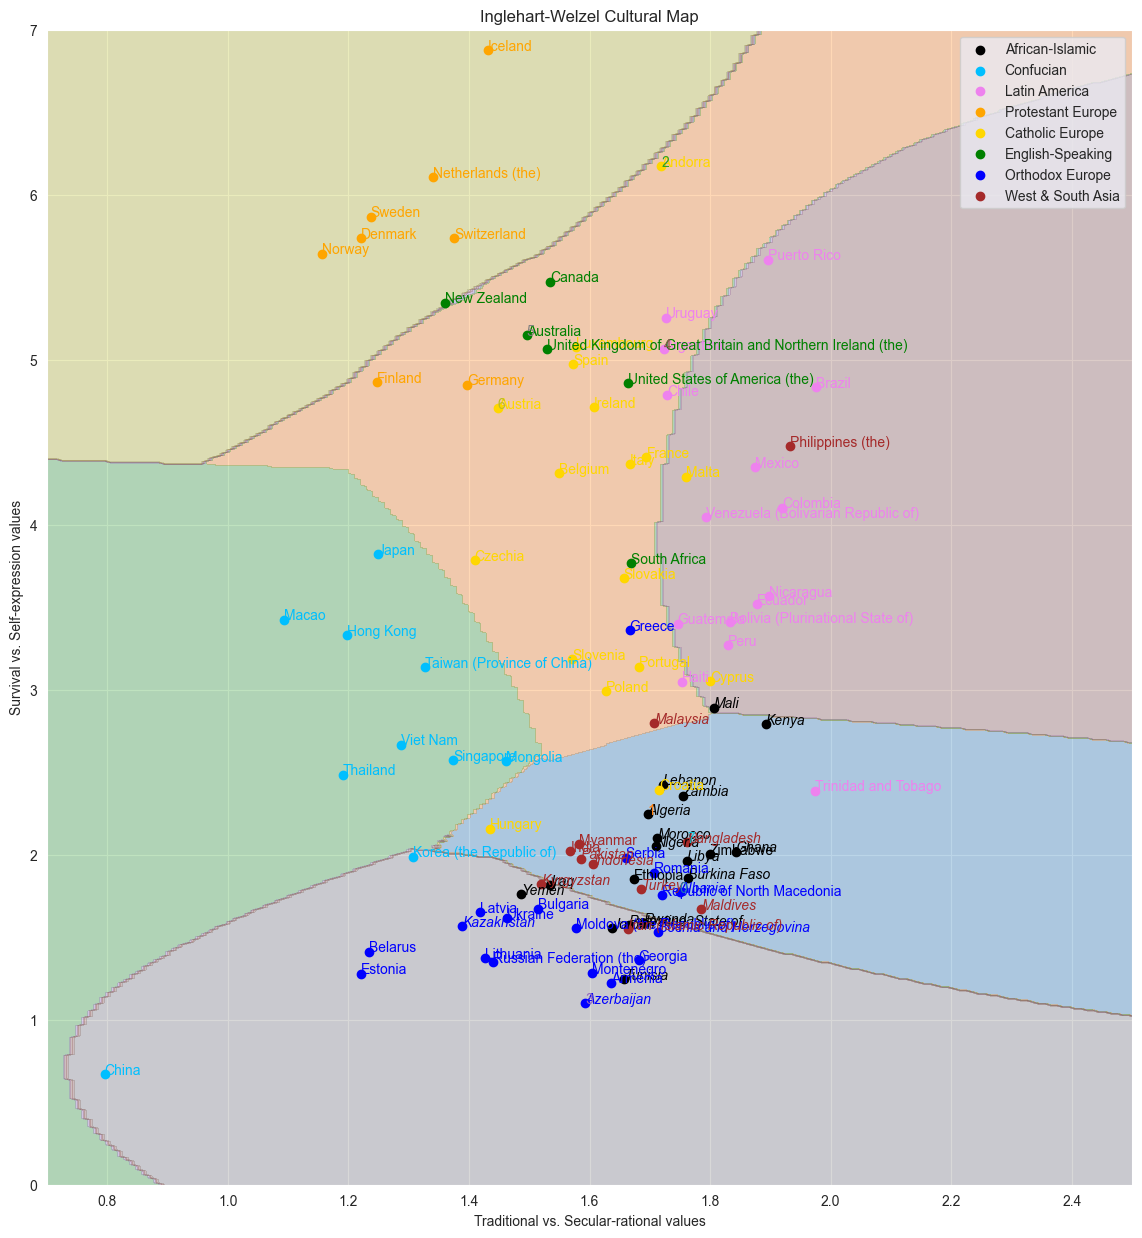

In [43]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Create a mesh grid
h = .01  # step size in the mesh
x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict classifications for each point in the mesh
Z = best_svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Define color map
cmap = plt.cm.get_cmap('tab10', len(np.unique(labels)))
norm = mcolors.BoundaryNorm(np.arange(-0.5, len(np.unique(labels)), 1), cmap.N)

# Plot the Cultural Map
plt.figure(figsize=(14, 15))


# Plot the decision boundary
plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3, norm=norm)

# Plot each cultural region with corresponding color and style
for region, color in cultural_region_colors.items():
    subset = country_scores_pca[country_scores_pca['Cultural Region'] == region]
    for i, row in subset.iterrows():
        if row['Islamic']:
            plt.text(row['PC1'], row['PC2'], row['Country'], color=color, fontsize=10, fontstyle='italic')
        else:
            plt.text(row['PC1'], row['PC2'], row['Country'], color=color, fontsize=10)

# Create a scatter plot with colored points based on cultural regions
for region, color in cultural_region_colors.items():
    subset = country_scores_pca[country_scores_pca['Cultural Region'] == region]
    plt.scatter(subset['PC1'], subset['PC2'], label=region, color=color)

# Add in labels for the Cultural Regions
for i, region in enumerate(np.unique(labels)):
    plt.text(x[i], y[i], region, color=cmap(norm(region)), fontsize=10)

# Add legend
plt.legend()
plt.xlabel('Traditional vs. Secular-rational values')
plt.ylabel('Survival vs. Self-expression values')
plt.title('Inglehart-Welzel Cultural Map')
plt.grid(True)
# x and y axis limits
plt.xlim(0.7, 2.5)
plt.ylim(0, 7)
plt.show()

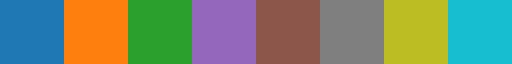

In [102]:
cmap

In [75]:
data_for_pca

,country_code,A008,A165,E018,E025,F063,F118,F120,G006,Y002,Y003,PC1,PC2
0,20.0,1.0,2.0,1.0,2.0,7.0,4.0,2.0,NaN,1.0,0.0,NaN,NaN
1,20.0,1.0,2.0,1.0,1.0,1.0,9.0,9.0,1.0,3.0,-1.0,6.033611,2.008317
2,20.0,2.0,2.0,1.0,1.0,8.0,10.0,5.0,3.0,2.0,2.0,8.917886,2.228894
3,20.0,2.0,2.0,2.0,2.0,1.0,6.0,4.0,NaN,2.0,0.0,NaN,NaN
4,20.0,2.0,2.0,2.0,1.0,4.0,8.0,5.0,NaN,1.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
666902,915.0,2.0,1.0,1.0,2.0,10.0,2.0,1.0,NaN,2.0,-3.0,NaN,NaN
666903,915.0,3.0,1.0,1.0,2.0,10.0,1.0,1.0,NaN,2.0,-3.0,NaN,NaN
666904,915.0,2.0,2.0,1.0,1.0,10.0,7.0,5.0,NaN,2.0,-3.0,NaN,NaN
666905,915.0,1.0,2.0,1.0,1.0,10.0,1.0,1.0,NaN,2.0,-3.0,NaN,NaN


In [39]:
# Merge the country codes DataFrame with the country scores DataFrame
# Add country names and cultural regions to the DataFrame  
country_scores_pca_full = data_for_pca.merge(country_scores_pca, left_on='country_code', right_on='Numeric', how='left')
country_scores_pca_full

,country_code_x,A008,A165,E018,E025,F063,F118,F120,G006,Y002,Y003,PC1_x,PC2_x,country_code_y,PC1_y,PC2_y,Country,Numeric,Cultural Region,Islamic
0,20.0,1.0,2.0,1.0,2.0,7.0,4.0,2.0,NaN,1.0,0.0,NaN,NaN,20.0,1.718869,6.174167,Andorra,20.0,Catholic Europe,False
1,20.0,1.0,2.0,1.0,1.0,1.0,9.0,9.0,1.0,3.0,-1.0,2.008317,6.033611,20.0,1.718869,6.174167,Andorra,20.0,Catholic Europe,False
2,20.0,2.0,2.0,1.0,1.0,8.0,10.0,5.0,3.0,2.0,2.0,2.228894,8.917886,20.0,1.718869,6.174167,Andorra,20.0,Catholic Europe,False
3,20.0,2.0,2.0,2.0,2.0,1.0,6.0,4.0,NaN,2.0,0.0,NaN,NaN,20.0,1.718869,6.174167,Andorra,20.0,Catholic Europe,False
4,20.0,2.0,2.0,2.0,1.0,4.0,8.0,5.0,NaN,1.0,1.0,NaN,NaN,20.0,1.718869,6.174167,Andorra,20.0,Catholic Europe,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394519,915.0,2.0,1.0,1.0,2.0,10.0,2.0,1.0,NaN,2.0,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
394520,915.0,3.0,1.0,1.0,2.0,10.0,1.0,1.0,NaN,2.0,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
394521,915.0,2.0,2.0,1.0,1.0,10.0,7.0,5.0,NaN,2.0,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
394522,915.0,1.0,2.0,1.0,1.0,10.0,1.0,1.0,NaN,2.0,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# Keep PC1_x, PC2_x, Country, Cultural Region, Islamic
country_scores_pca_full = country_scores_pca_full[['PC1_x', 'PC2_x', 'Country', 'Cultural Region', 'Islamic']]
country_scores_pca_full = country_scores_pca_full.rename(columns={"PC1_x": "PC1", "PC2_x": "PC2"})
country_scores_pca_full

,PC1,PC2,Country,Cultural Region,Islamic
0,NaN,NaN,Andorra,Catholic Europe,False
1,2.008317,6.033611,Andorra,Catholic Europe,False
2,2.228894,8.917886,Andorra,Catholic Europe,False
3,NaN,NaN,Andorra,Catholic Europe,False
4,NaN,NaN,Andorra,Catholic Europe,False
...,...,...,...,...,...
394519,NaN,NaN,NaN,NaN,NaN
394520,NaN,NaN,NaN,NaN,NaN
394521,NaN,NaN,NaN,NaN,NaN
394522,NaN,NaN,NaN,NaN,NaN


In [41]:
# Drop NA
country_scores_pca_full = country_scores_pca_full.dropna()
country_scores_pca_full

,PC1,PC2,Country,Cultural Region,Islamic
1,2.008317,6.033611,Andorra,Catholic Europe,False
2,2.228894,8.917886,Andorra,Catholic Europe,False
7,1.868101,7.718846,Andorra,Catholic Europe,False
10,2.183876,6.838580,Andorra,Catholic Europe,False
11,1.411516,0.735962,Andorra,Catholic Europe,False
...,...,...,...,...,...
392417,1.783397,1.523119,Zambia,African-Islamic,True
392418,1.651820,5.081578,Zambia,African-Islamic,True
392419,1.877996,2.267367,Zambia,African-Islamic,True
392420,1.196594,4.056614,Zambia,African-Islamic,True


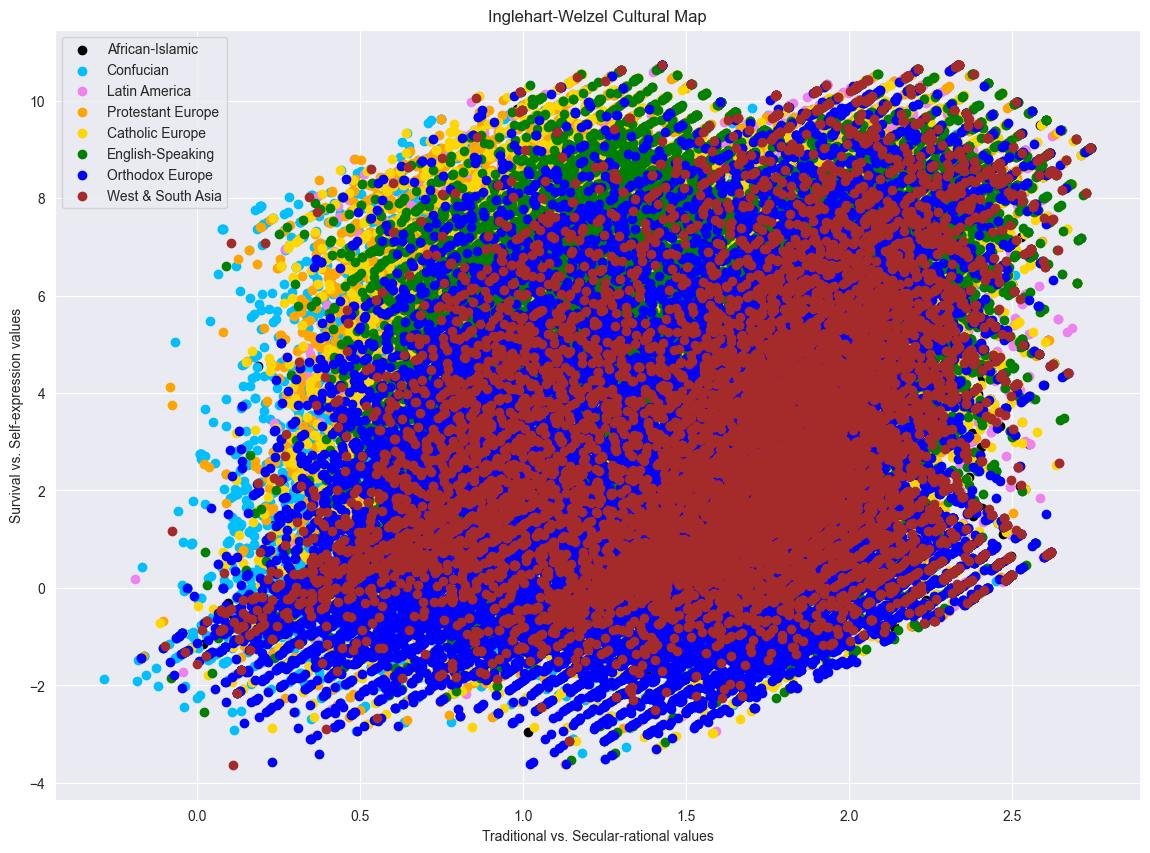

In [42]:
# Plot the Cultural Map
plt.figure(figsize=(14, 10))

# Create a scatter plot with colored points based on cultural regions
for region, color in cultural_region_colors.items():
    subset = country_scores_pca_full[country_scores_pca_full['Cultural Region'] == region]
    plt.scatter(subset['PC1'], subset['PC2'], label=region, color=color)

plt.xlabel('Traditional vs. Secular-rational values')
plt.ylabel('Survival vs. Self-expression values')
plt.title('Inglehart-Welzel Cultural Map')

# Add legend
plt.legend()

plt.grid(True)
plt.show()